## Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.svm import LinearSVC
from umap import UMAP

sns.set_theme(context="paper", style="ticks")
random_state = 42

Load data


In [2]:
train = pd.read_csv("data\\train.csv")
test = pd.read_csv("data\\test.csv")

test_ID = test.PassengerId

Preprocessing


In [3]:
oh_enc = OneHotEncoder(sparse=False)
ordinal_enc = OrdinalEncoder(
    categories=[["A", "B", "C", "D", "E", "F", "G", "T", np.nan]],
)

# Ticket, Cabin, Name, PassengerID: Non informative
# Sex, Embarked, Deck: Will be encoded
drop_cols = ["Ticket", "Cabin", "Name", "PassengerId", "Sex", "Embarked", "Deck"]
train["Deck"] = pd.DataFrame(train.Cabin.str.extract("([A-Z])", expand=False))
test["Deck"] = pd.DataFrame(test.Cabin.str.extract("([A-Z])", expand=False))

In [4]:
train_y = train.Survived
train_X = train.drop("Survived", axis=1)

In [5]:
estimators = [
    ("knnc", KNeighborsClassifier(weights="distance", n_neighbors=100, n_jobs=-1)),
    ("gpc", GaussianProcessClassifier(random_state=random_state, warm_start=True)),
    (
        "rfc",
        RandomForestClassifier(
            random_state=random_state, class_weight="balanced_subsample", n_jobs=-1
        ),
    ),
    ("SVC", LinearSVC(max_iter=100000, random_state=random_state)),
    ("gnb", GaussianNB()),
]

In [37]:
encoder = ColumnTransformer(
    [
        ("oh", oh_enc, make_column_selector("Sex|Embarked")),
        ("ord", ordinal_enc, make_column_selector("Deck")),
        ("selector", "drop", drop_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=True,
)

imputer = SimpleImputer(add_indicator=True, strategy="constant", fill_value=0)

scaler = RobustScaler(unit_variance=True)

reducer = UMAP(
    n_components=5,
    n_neighbors=30,
    target_weight=0.5,
    metric="correlation",
    # random_state=random_state
)

class_comp = StackingClassifier(
    estimators=estimators,
    n_jobs=-1,
    verbose=0,
)

In [38]:
pipeline = make_pipeline(encoder, imputer, scaler, reducer, class_comp)

In [39]:
pipeline.fit(X=train_X, y=train_y)

pred_y = pipeline.predict(test)

In [40]:
proba = pipeline.predict_proba(test)
entropy = -np.sum(np.log2(proba) * proba, axis=1)

Plot training data


<AxesSubplot:>

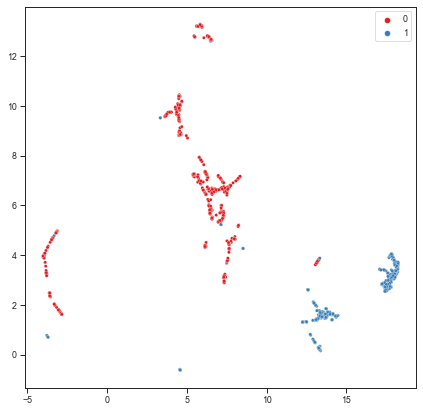

In [41]:
plt.figure(figsize=(7, 7))
sns.scatterplot(
    x=pipeline["umap"].embedding_[:, 0],
    y=pipeline["umap"].embedding_[:, 1],
    hue=train_y.to_numpy().flatten(),
    # alpha=proba,
    palette="Set1",
    s=10,
)

Plot test data


C:\tools\miniconda3\lib\site-packages\seaborn\relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


<AxesSubplot:>

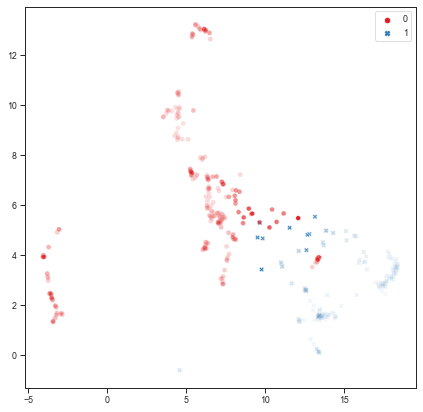

In [47]:
plt.figure(figsize=(7, 7))
sns.scatterplot(
    x=pipeline[:4].transform(X=test)[:, 0],
    y=pipeline[:4].transform(X=test)[:, 1],
    style=pred_y,
    palette="Set1",
    hue=pred_y,
    # hue=entropy,
    alpha=entropy,
    sizes=(3, 20),
    # s=10
)

<AxesSubplot:ylabel='Percent'>

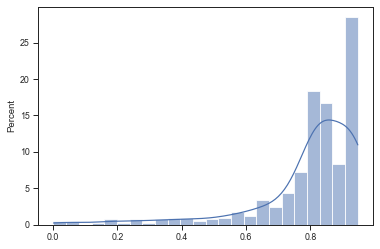

In [50]:
sns.histplot(
    1 - entropy,
    # cumulative=True,
    kde=True,
    kde_kws={"cut": 0},
    stat="percent",
)

Save predictions as csv


In [44]:
submission = pd.DataFrame(
    columns=["PassengerId", "Survived"], data=zip(test_ID, pred_y)
)
submission.to_csv("submission.csv", index=False)

In [45]:
data = pd.read_csv("data\\train.csv")
X_data = data.drop("Survived", axis=1)
y_data = data.Survived

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, random_state=random_state
)